In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
!pip install gym-super-mario-bros
import gym_super_mario_bros
from IPython.display import clear_output
from gym import wrappers
import time as time
# !pip install pyvirtualdisplay
# !apt update
# !apt install xvfb
from pyvirtualdisplay import Display
from IPython import display
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/grap

Successfully loaded MarioBros environment.
State shape: (240, 256, 3)
Action space: Discrete(7)
Reduced state shape: (200, 200, 3)


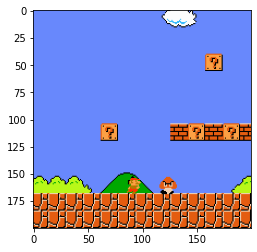

In [2]:
# Testing the environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

# For rendering videos
# env = wrappers.Monitor(env,'./', force=True)
# d = Display()
# d.start()

done = True

for step in range(200):
    if done:
        state = env.reset()
    state, reward, done, info = env.step(1)
    if step == 150:
      saved_state = state.copy()

env.close()

print(f'Successfully loaded MarioBros environment.')
print(f'State shape: {state.shape}')
print(f'Action space: {env.action_space}')

def crop_state(state):
  return state[40:, 28:256-28 ,:]

print(f'Reduced state shape: {crop_state(saved_state).shape}')
plt.imshow(crop_state(saved_state))

In [3]:
from torchsummary import summary

class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()

    self.l1 = nn.Conv2d(in_channels=12, out_channels=64, kernel_size=4, stride=2, padding=1)
    self.l2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
    self.l3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2)
    self.l4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=4, stride=2, padding=1)
    self.l5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=4, stride=2)
    self.l6 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=2, stride=2)

    self.relu = nn.LeakyReLU()

  def forward(self, x):
    x1 = self.relu(self.l1(x))
    x2 = self.relu(self.l2(x1))
    x3 = self.relu(self.l3(x2))
    x4 = self.relu(self.l4(x3))
    x5 = self.relu(self.l5(x4))
    x_encoded = self.l6(x5)
  
    cache = [x1, x2, x3, x4, x5]

    return x_encoded, cache


class Decoder(nn.Module):
  def __init__(self, n_actions):
    super(Decoder, self).__init__()

    # Conv Layers
    self.decode1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride= 3)
    self.decode2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride= 2)
    self.decode3 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride= 2, padding=1)
    self.decode4 = nn.ConvTranspose2d(in_channels=512, out_channels=128, kernel_size=4, stride= 2)
    self.decode5 = nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=4, stride= 2, padding=1)
    self.decode6 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride= 2, padding=1)
    self.pixel_logits = nn.Conv2d(in_channels = 64, out_channels = 256*3, kernel_size = 3, padding=1)

    # Action Embeddings
    self.embed1 = nn.Linear(n_actions, 256*5*5)
    self.embed2 = nn.Linear(n_actions, 256*12*12)
    self.embed3 = nn.Linear(n_actions, 256*24*24)
    self.embed4 = nn.Linear(n_actions, 128*50*50)
    self.embed5 = nn.Linear(n_actions, 64*100*100)

    self.relu = nn.LeakyReLU()

  def forward(self, x, cache, action_onehot, latent):
    # Embed actions
    a1_embedded = self.embed1(action_onehot).view(-1, 256, 5, 5)
    a2_embedded = self.embed2(action_onehot).view(-1, 256, 12, 12)
    a3_embedded = self.embed3(action_onehot).view(-1, 256, 24, 24)
    a4_embedded = self.embed4(action_onehot).view(-1, 128, 50, 50)
    a5_embedded = self.embed5(action_onehot).view(-1, 64, 100, 100)

    # Deconv + Skip Connections + Action Multiplication
    x = latent*x
    y1 = self.relu(self.decode1(x))
    y1 = y1*a1_embedded
    y1 = torch.cat([y1, cache[-1]], dim=1)
    y2 = self.relu(self.decode2(y1))
    y2 = y2*a2_embedded
    y2 = torch.cat([y2, cache[-2]], dim=1)
    y3 = self.relu(self.decode3(y2))
    y3 = y3*a3_embedded
    y3 = torch.cat([y3, cache[-3]], dim=1)
    y4 = self.relu(self.decode4(y3))
    y4 = y4*a4_embedded
    y4 = torch.cat([y4, cache[-4]], dim=1)
    y5 = self.relu(self.decode5(y4))
    y5 = y5*a5_embedded
    y5 = torch.cat([y5, cache[-5]], dim=1)
    y = self.relu(self.decode6(y5))
    logits = self.pixel_logits(y)

    return logits.view(-1, 256, 3, 200, 200)


class InferenceNetwork(nn.Module):
    # Takes 4 last frames and next state, outputs mu and logvar of p(z| s_t, s_{t-1})
    # Note: Our latent is two dimensional, mu and logvar correspond to N(mu, sigma) for each bit (independently)
    def __init__(self, n_actions):
        super(InferenceNetwork, self).__init__()

        # General Parameters
        self.n_actions = n_actions

        # Layers
        self.latent1 = nn.Conv2d(in_channels=3*5, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.latent2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.latent3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2)
        self.latent4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.latent5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=4, stride=2)
        self.latent_mu = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=2, stride=2)
        self.latent_logvar = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=2, stride=2)

        # Action Layers
        self.latent_action_embedding = nn.Linear(n_actions, 64*100*100)

        # Activation Function
        self.relu = nn.LeakyReLU()

    def forward(self, last_states, next_state, action_onehot):
        state = torch.cat([last_states, next_state], dim=1)
        action_embedded = self.latent_action_embedding(action_onehot).view(-1, 64, 100, 100)
        z = self.relu(self.latent1(state))
        z = z*action_embedded
        z = self.relu(self.latent2(z))
        z = self.relu(self.latent3(z))
        z = self.relu(self.latent4(z))
        z = self.relu(self.latent5(z))
        
        mu = self.latent_mu(z)
        log_var = self.latent_logvar(z)

        return mu, log_var

    def posterior_sample(self, current_state, next_state, action):
        mu, log_var = self.forward(current_state, next_state, action)
        std_deviation = torch.exp(0.5*log_var)
        random_noise = torch.randn_like(std_deviation)
        sample = mu + random_noise * std_deviation
        return sample, mu, log_var

    def prior_sample(self, batch_size):
        sample = torch.randn((batch_size, 256, 2, 2))
        return sample


class StochasticModel(nn.Module):
  def __init__(self, n_actions):
    super(StochasticModel, self).__init__()

    self.encoder = Encoder()
    self.decoder = Decoder(n_actions)
  
  def forward(self, states, actions, latents):
    x_encoded, cache = self.encoder(states)
    y_logits = self.decoder(x_encoded, cache, actions, latents)

    return y_logits

  def predict(self, states, actions, latents):
    state_prediction = self.forward(states, actions, latents)
    state_prediction = torch.argmax(F.softmax(state_prediction, dim=1), dim=1)

    return state_prediction
  
  def predict_from_logits(self, state_prediction):
    state_prediction = torch.argmax(F.softmax(state_prediction, dim=1), dim=1)
    
    return state_prediction


input = crop_state(saved_state)
input = torch.from_numpy(input.copy()).permute(2,0,1).unsqueeze(0).float()
input = torch.repeat_interleave(input, 4, dim=1)
action_input = torch.tensor([1,0,0,0,0,0,0]).unsqueeze(0).float()


# Encoder Summary
enc = Encoder().cuda()
print('Encoder Summary: ')
summary(enc, (12, 200, 200))

# Testing the forward pass
batch_size, n_actions = 8, 7
last_frames = torch.randn((batch_size, 3*4, 200, 200)).cuda()
next_frame = torch.randn((batch_size, 3, 200, 200)).cuda()
actions = torch.randn((batch_size, n_actions)).cuda()

infnet = InferenceNetwork(n_actions= n_actions).cuda()
model = StochasticModel(n_actions = n_actions).cuda()
latent, mu, logvar = infnet.posterior_sample(last_frames, next_frame, actions)
frame_prediction = model.predict(last_frames, actions, latent)
print(f'Frame prediction shape: {frame_prediction.shape}')

enc_params = sum([p.numel() for p in model.encoder.parameters()])
dec_params = sum([p.numel() for p in model.decoder.parameters()])
inf_params = sum([p.numel() for p in infnet.parameters()])
total_params = enc_params + dec_params + inf_params

print(f'# Encoder params: {enc_params}')
print(f'# Decoder params: {dec_params}')
print(f'# Inferencenet params: {inf_params} \n')
print(f'# Total params: {total_params}')


Encoder Summary: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]          12,352
         LeakyReLU-2         [-1, 64, 100, 100]               0
            Conv2d-3          [-1, 128, 50, 50]         131,200
         LeakyReLU-4          [-1, 128, 50, 50]               0
            Conv2d-5          [-1, 256, 24, 24]         524,544
         LeakyReLU-6          [-1, 256, 24, 24]               0
            Conv2d-7          [-1, 256, 12, 12]       1,048,832
         LeakyReLU-8          [-1, 256, 12, 12]               0
            Conv2d-9            [-1, 256, 5, 5]       1,048,832
        LeakyReLU-10            [-1, 256, 5, 5]               0
           Conv2d-11            [-1, 256, 2, 2]         262,400
Total params: 3,028,160
Trainable params: 3,028,160
Non-trainable params: 0
----------------------------------------------------------------
Input si

In [4]:
class FrameDataset():
  def __init__(self, max_size):
    self.max_size = max_size
    self.states = [None for i in range(max_size)]
    self.actions = [None for i in range(max_size)]
    self.counter = 0
    self.filled = 0

  def write_state_action(self, state, action):
    self.states[self.counter] = state
    self.actions[self.counter] = action
    self.counter += 1
    if self.filled < self.max_size-1:
      self.filled += 1
    if self.counter == self.max_size:
      self.counter = 0

  def sample(self, batch_size, n_actions):
     # Samples four frames, actions and next frame
     last_frames = []
     last_action = []
     next_frame = []

     for i in range(batch_size):
       start_idx = np.random.randint(self.filled-4)
       sampled_frames = self.states[start_idx:start_idx+4]
       sampled_next_frame = self.states[start_idx+4]
       sampled_action = self.actions[start_idx+4]
       # cat channels for sampled_frames of size (3, 200, 200)
       sampled_frames = torch.cat(sampled_frames, dim=0).unsqueeze(0).cuda()
       # cast sampled_next_frames into size (1, 3, 200, 200)
       sampled_next_frame = sampled_next_frame.unsqueeze(0).cuda()
       # cast sampled_actions into one-hot of size (1, n_actions)
       sampled_action = F.one_hot(torch.tensor(sampled_action), n_actions).unsqueeze(0).float().cuda()

       last_frames.append(sampled_frames)
       last_action.append(sampled_action)
       next_frame.append(sampled_next_frame)
       
     return torch.cat(last_frames, dim=0), torch.cat(last_action, dim=0), torch.cat(next_frame, dim=0)

In [5]:
dataset = FrameDataset(10000)


def preprocess_state(state):
  cropped_state = state[40:, 28:256-28 ,:]
  return torch.tensor(cropped_state.copy()).float().permute(2,0,1)

env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env.reset()

action = 1
state, reward, done, info = env.step(action)
dataset.write_state_action(preprocess_state(state), action)

## Training Test

In [6]:
for episode in range(20):
  print(episode)
  env = gym_super_mario_bros.make('SuperMarioBros-v0')
  env = JoypadSpace(env, SIMPLE_MOVEMENT)
  env.reset()
  #action = env.action_space.sample()
  action = 1

  for step in range(25):
    if done: 
      state = env.reset()
    state, reward, done, info = env.step(action)
    # action = env.action_space.sample()
    action = 1
    dataset.write_state_action(preprocess_state(state), action)

  env.close()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [7]:
last_frames, last_action, next_frame = dataset.sample(8, 7)
print(last_frames.shape)
print(last_action.shape)
print(next_frame.shape)

torch.Size([8, 12, 200, 200])
torch.Size([8, 7])
torch.Size([8, 3, 200, 200])


In [8]:
# Initialize Networks
n_actions = 7
infnet = InferenceNetwork(n_actions= n_actions).cuda()
model = StochasticModel(n_actions = n_actions).cuda()

In [ ]:
# Train the world model from sampled frames and actions in the FrameDataset
N = 100
batch_size = 16
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(infnet.parameters()) + list(model.parameters()), lr=5e-4)
ETA_S = 1
ETA_KL = 0


for i in range(N):
    last_frames, action, next_frame = dataset.sample(batch_size, n_actions)
    latents, mu, log_var = infnet.posterior_sample(last_frames, next_frame, action)
    frame_likelihoods = model.forward(last_frames, action, latents)
    # print(frame_likelihoods.shape)
    # print(next_frame.shape)
    # print(mu.shape)
    # print(log_var.shape)
    ce_loss = criterion(frame_likelihoods, next_frame.long())
    kl_loss = -torch.mean(0.5*torch.sum(1 + log_var.view(latents.shape[0], -1) - mu.view(latents.shape[0], -1)**2\
              -torch.exp(log_var.view(latents.shape[0], -1)), dim=1))

    loss = ETA_S * ce_loss + ETA_KL * kl_loss
    print(f'Iteration {i}: Loss: {loss}\n')

    # Optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()

    # Visualization
    #losses.append(loss.item())
    #print(loss.item())


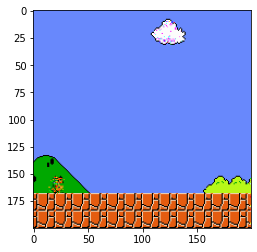

In [10]:
prior_latents = infnet.prior_sample(batch_size).cuda()
plt.imshow(model.predict(last_frames, action, prior_latents)[0].permute(1,2,0).detach().cpu().numpy().astype(int))

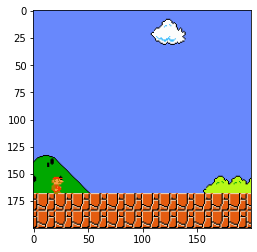

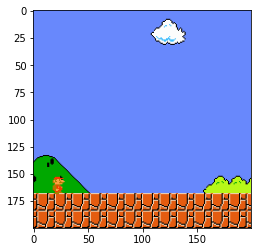

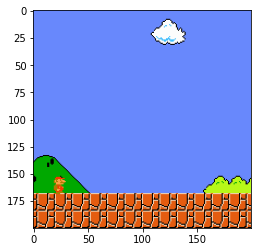

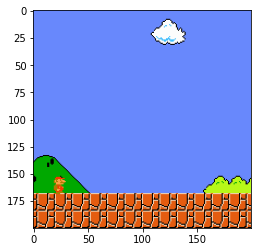

torch.Size([1, 12, 200, 200])


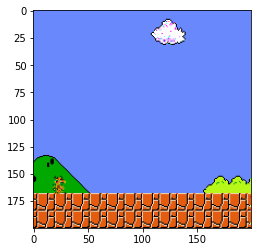

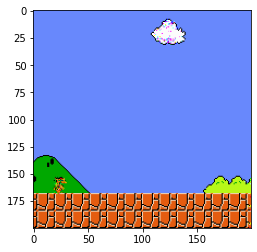

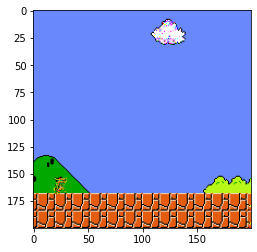

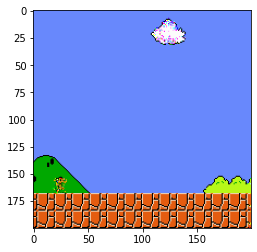

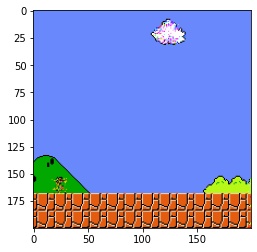

In [11]:
test_frames = last_frames[2].unsqueeze(0)
plt.imshow(test_frames[0,:3,:,:].permute(1,2,0).detach().cpu().numpy().astype(int))
plt.show()
plt.imshow(test_frames[0,3:6,:,:].permute(1,2,0).detach().cpu().numpy().astype(int))
plt.show()
plt.imshow(test_frames[0,6:9,:,:].permute(1,2,0).detach().cpu().numpy().astype(int))
plt.show()
plt.imshow(test_frames[0,9:12,:,:].permute(1,2,0).detach().cpu().numpy().astype(int))
plt.show()
#test_action = action[0].unsqueeze(0)
test_action = F.one_hot(torch.tensor(1),n_actions).float().cuda()
print(test_frames.shape)


for i in range(5):
  prior_latents = infnet.prior_sample(1).cuda()
  predicted_frame = model.predict(test_frames, test_action, prior_latents)
  plt.imshow(predicted_frame[0].permute(1,2,0).detach().cpu().numpy().astype(int))
  plt.show()
  test_frames = torch.cat([test_frames[:,3:,:,:], predicted_frame], dim=1)




## Bootstrapped Training

In [12]:
class FrameDataset():
  def __init__(self, max_size):
    self.max_size = max_size
    self.states = [None for i in range(max_size)]
    self.actions = [None for i in range(max_size)]
    self.counter = 0
    self.filled = 0

  def write_state_action(self, state, action):
    self.states[self.counter] = state
    self.actions[self.counter] = action
    self.counter += 1
    if self.filled < self.max_size-1:
      self.filled += 1
    if self.counter == self.max_size:
      self.counter = 0

  def sample(self, batch_size, n_actions, seq_len):
     # Samples four frames, actions and next frame
     last_frames = []
     last_action = []
     next_frame = []

     for i in range(batch_size):
       start_idx = np.random.randint(self.filled-seq_len)
       sampled_frames = self.states[start_idx:start_idx+seq_len]
       sampled_next_frame = self.states[start_idx+seq_len]
       # Todo: Check if the actions align with the sampled frames
       sampled_action = self.actions[start_idx+seq_len-3:start_idx+seq_len-1]
       # cat channels for sampled_frames of size (3, 200, 200)
       sampled_frames = torch.cat(sampled_frames, dim=0).unsqueeze(0).cuda()
       # cast sampled_next_frames into size (1, 3, 200, 200)
       sampled_next_frame = sampled_next_frame.unsqueeze(0).cuda()
       # cast sampled_actions into one-hot of size (2, n_actions)
       sampled_action = F.one_hot(torch.tensor(sampled_action), n_actions).unsqueeze(0).float().cuda()

       last_frames.append(sampled_frames)
       last_action.append(sampled_action)
       next_frame.append(sampled_next_frame)
       
     return torch.cat(last_frames, dim=0), torch.cat(last_action, dim=0), torch.cat(next_frame, dim=0)

class BootstrapDataset():
  def __init__(self, max_size):
    self.max_size = max_size
    self.dataset = [None for i in range(max_size)]
    self.counter = 0
    self.filled = 0

  def write_tuple(self, last_frames, action, predicted_frame):
    self.dataset[self.counter] = (last_frames, action, predicted_frame)
    self.counter += 1
    if self.filled < self.max_size-1:
      self.filled += 1
    if self.counter == self.max_size:
      self.counter = 0

  def sample(self, batch_size):
     # Samples four frames, actions and next frame
     last_frames = []
     last_action = []
     next_frame = []

     for i in range(batch_size):
       rand_idx = np.random.randint(self.filled)
       sampled_frames, sampled_action, sampled_next_frame = self.dataset[rand_idx]
       last_frames.append(sampled_frames)
       last_action.append(sampled_action)
       next_frame.append(sampled_next_frame)

       
     return torch.cat(last_frames, dim=0).cuda(), torch.cat(last_action, dim=0).cuda(), torch.cat(next_frame, dim=0).cuda()

In [13]:
def explore(n_episodes, episode_length):
  for episode in range(n_episodes):
    print(episode)
    env = gym_super_mario_bros.make('SuperMarioBros-v0')
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    env.reset()
    done=True
    #action = env.action_space.sample()
    action = 1

    for step in range(episode_length):
      if done: 
        state = env.reset()
      state, reward, done, info = env.step(action)
      # action = env.action_space.sample()
      action = 1
      dataset.write_state_action(preprocess_state(state), action)

    env.close()

In [ ]:
bootstrap_dataset = BootstrapDataset(100)
dataset = FrameDataset(10000)

n_actions = 7
infnet = InferenceNetwork(n_actions= n_actions).cuda()
model = StochasticModel(n_actions = n_actions).cuda()

N = 5000

batch_size = 8
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(infnet.parameters()) + list(model.parameters()), lr=5e-4)
ETA_S = 1
ETA_KL = 0.1

# Explore only at start (for now)
explore(10, 200)

for i in range(N):

    if bootstrap_dataset.filled < batch_size//2:
      # Sample (frame_0, frame_1, frame_2, frame_3, frame_4), (frame_5 == next_frame) and (action_3, action_4)
      last_frames, actions, next_frame = dataset.sample(batch_size//2, n_actions, seq_len=5)
      first_four_frames = last_frames[:,:12,:,:]
      action_3 = actions[:,0,:]
      action_4 = actions[:,1,:]
      targets = next_frame
      latents, mu, log_var = infnet.posterior_sample(first_four_frames, next_frame, action_3)
      frame_likelihoods = model.forward(first_four_frames, action_3, latents)
      predicted_frame = model.predict_from_logits(frame_likelihoods)

    else:
      # Sample from bootstrap and frame dataset, concatenate to a single batch
      last_frames, actions, next_frame = dataset.sample(batch_size//2, n_actions, seq_len=5)
      first_four_frames = last_frames[:,:12,:,:]
      action_3 = actions[:,0,:]
      action_4 = actions[:,1,:]
      bootstrap_last_frames, bootstrap_actions, bootstrap_next_frame = bootstrap_dataset.sample(batch_size//2)
      last_frames_input = torch.cat([first_four_frames, bootstrap_last_frames], dim=0)
      targets = torch.cat([next_frame, bootstrap_next_frame], dim=0)
      action_input = torch.cat([action_3, bootstrap_actions], dim=0)
      latents, mu, log_var = infnet.posterior_sample(last_frames_input, targets, action_input)
      frame_likelihoods = model.forward(last_frames_input, action_input, latents)
      
      # Save predicted frame for samples in frame_dataset
      predicted_frame = model.predict_from_logits(frame_likelihoods[:batch_size//2])

    # Write to bootstrap_dataset
    bootstrap_frames = torch.cat([last_frames[:,3:12,:,:], predicted_frame], dim=1)
    for j in range(batch_size//2):
      # Write x=(frame_1, frame_2, frame_3, predicted_frame) and y=(frame_5) with taken action: action_4
      bootstrap_dataset.write_tuple(bootstrap_frames[j].unsqueeze(0).cpu(), action_4[j].unsqueeze(0).cpu(), next_frame[j].unsqueeze(0).cpu())
  

    ce_loss = criterion(frame_likelihoods, targets.long())
    kl_loss = -torch.mean(0.5*torch.sum(1 + log_var.view(latents.shape[0], -1) - mu.view(latents.shape[0], -1)**2\
              -torch.exp(log_var.view(latents.shape[0], -1)), dim=1))

    loss = ETA_S * ce_loss + ETA_KL * kl_loss
    print(f'Iteration {i}: Loss: {loss}\n')


    # Optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



torch.Size([2, 12, 200, 200])
torch.Size([2, 7])
torch.Size([2, 3, 200, 200])


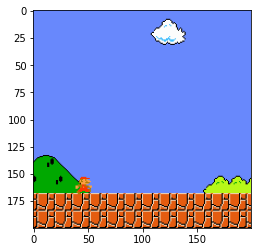

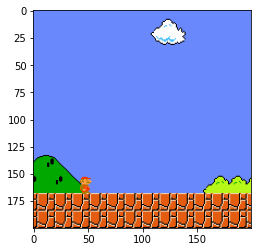

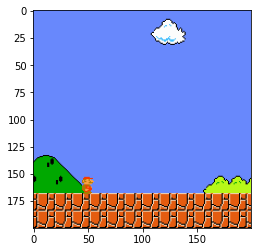

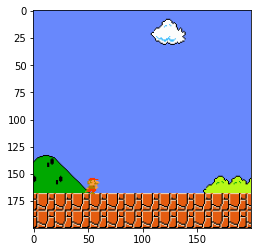

Taken action: tensor([0., 1., 0., 0., 0., 0., 0.], device='cuda:0')


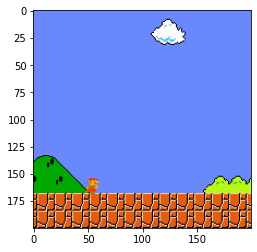

In [16]:
test_last_frames, test_action, test_next_frame = bootstrap_dataset.sample(2)

print(test_last_frames.shape)
print(test_action.shape)
print(test_next_frame.shape)

def plot_prediction_tuple(batch_idx, last_frames, action, next_frame):
  plt.imshow(last_frames[batch_idx,:3,:,:].permute(1,2,0).detach().cpu().numpy().astype(int))
  plt.show()
  plt.imshow(last_frames[batch_idx,3:6,:,:].permute(1,2,0).detach().cpu().numpy().astype(int))
  plt.show()
  plt.imshow(last_frames[batch_idx,6:9,:,:].permute(1,2,0).detach().cpu().numpy().astype(int))
  plt.show()
  plt.imshow(last_frames[batch_idx,9:12,:,:].permute(1,2,0).detach().cpu().numpy().astype(int))
  plt.show()
  
  print(f'Taken action: {action[batch_idx]}')

  plt.imshow(next_frame[batch_idx].permute(1,2,0).detach().cpu().numpy().astype(int))

plot_prediction_tuple(0, test_last_frames, test_action, test_next_frame)

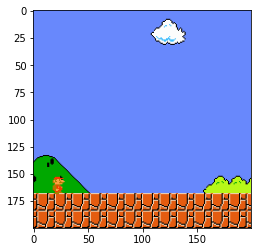

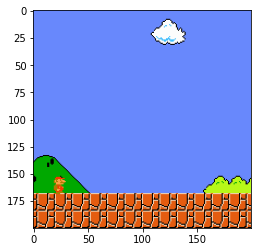

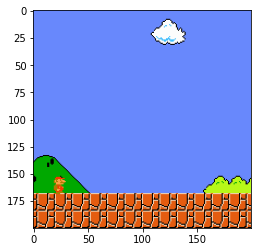

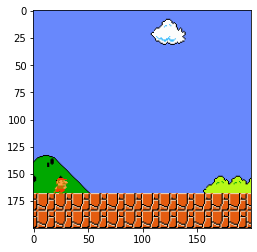

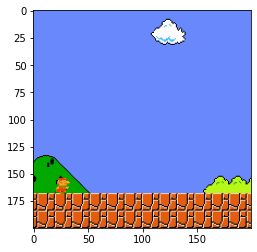

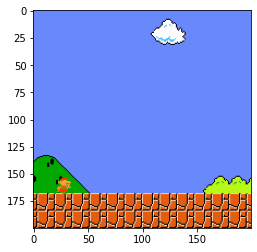

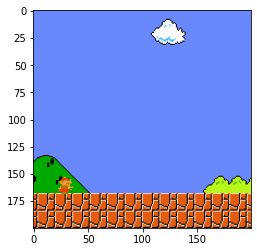

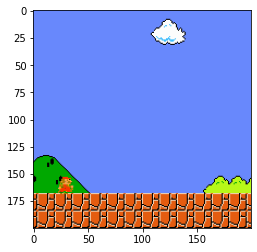

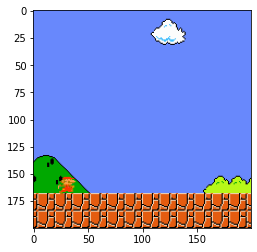

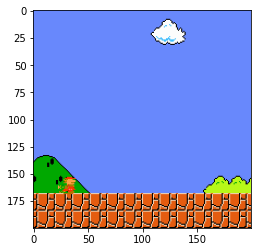

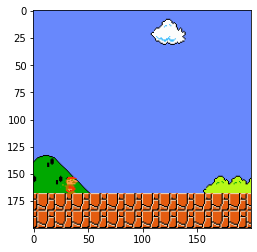

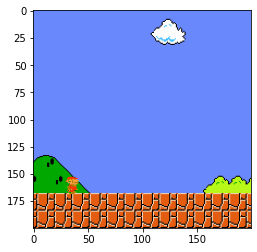

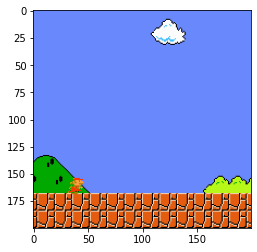

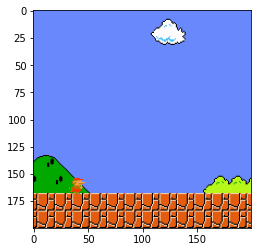

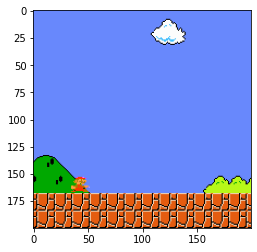

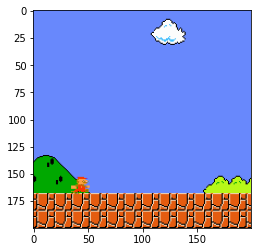

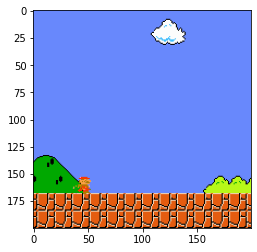

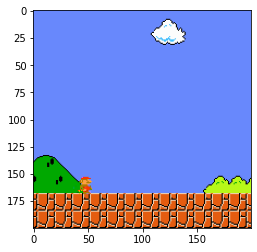

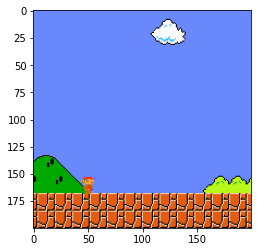

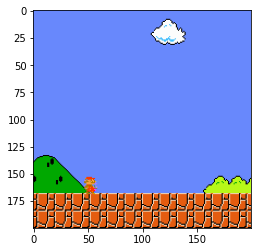

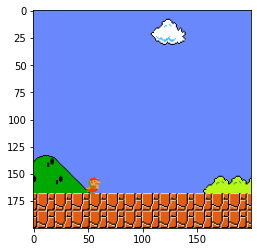

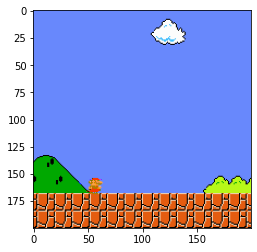

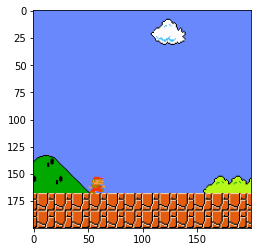

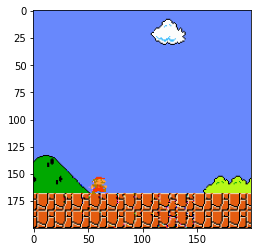

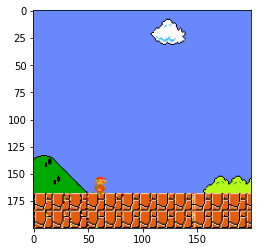

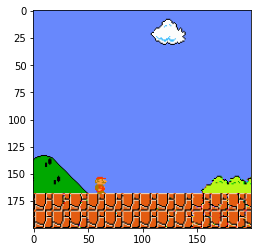

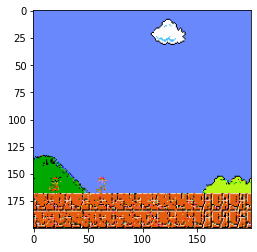

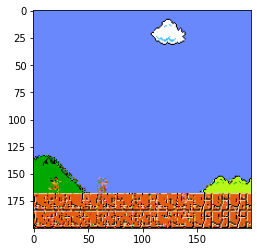

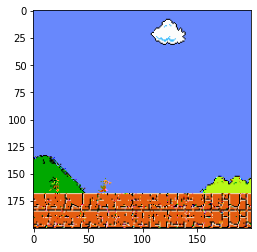

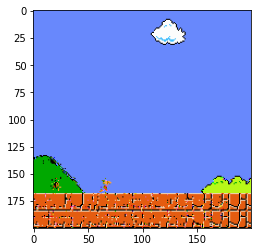

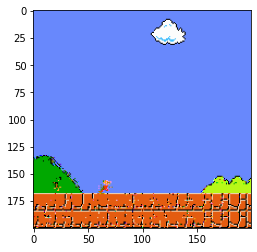

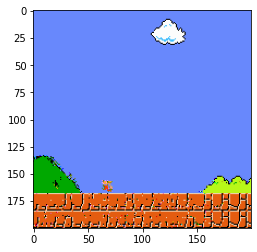

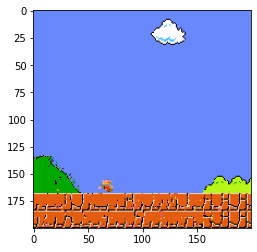

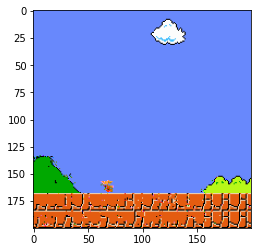

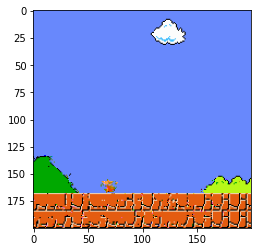

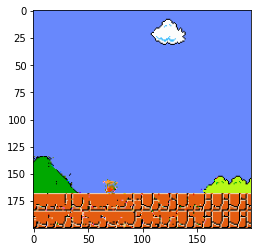

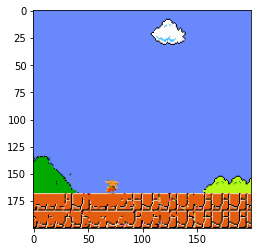

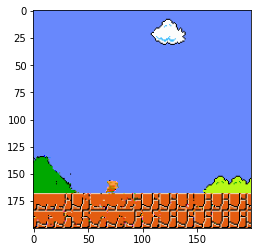

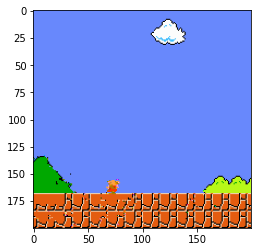

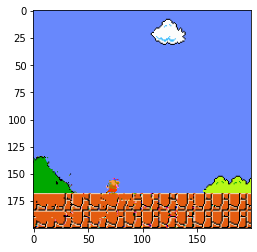

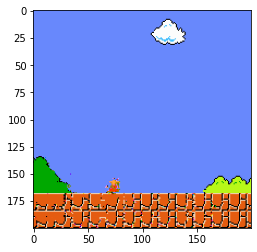

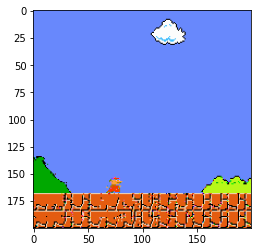

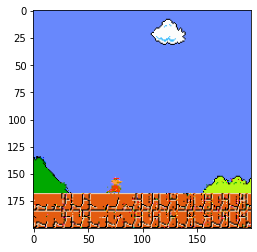

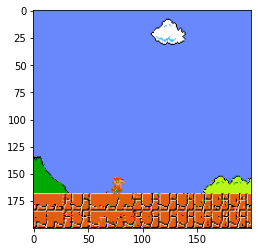

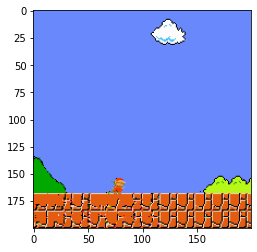

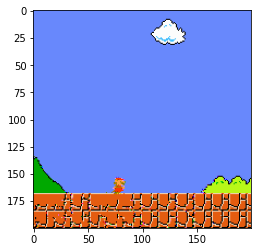

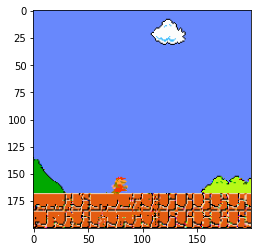

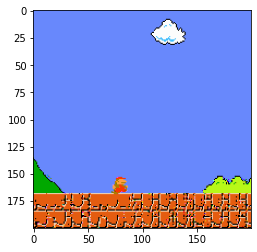

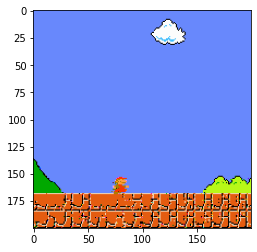

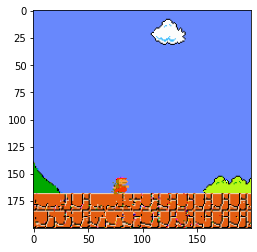

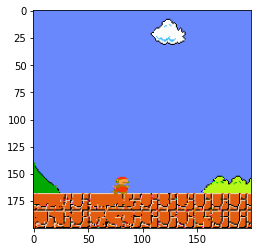

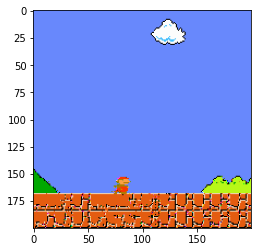

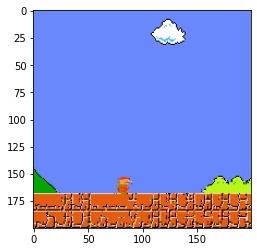

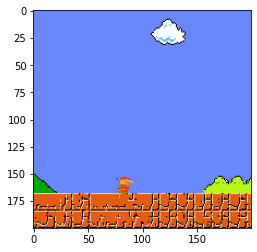

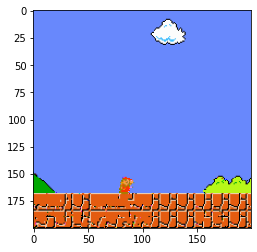

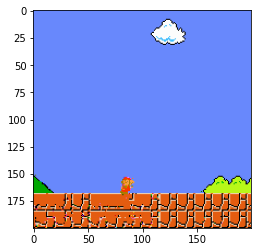

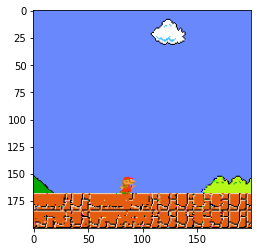

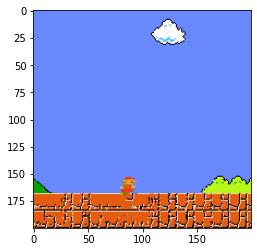

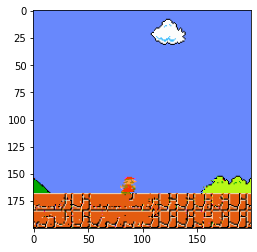

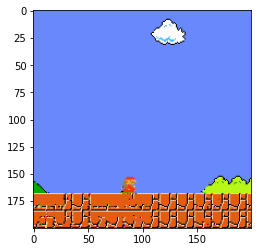

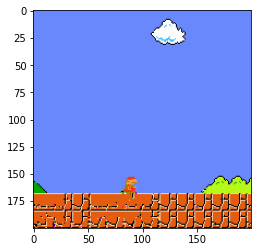

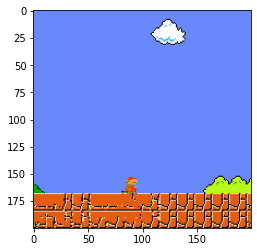

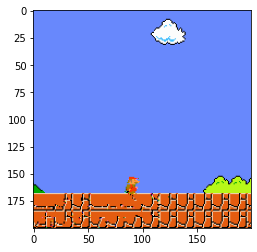

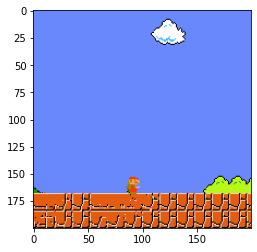

In [41]:
test_frames, test_acts, test_next_frames = dataset.sample(1, n_actions, seq_len=4)
plt.imshow(test_frames[0,:3,:,:].permute(1,2,0).detach().cpu().numpy().astype(int))
plt.show()
plt.imshow(test_frames[0,3:6,:,:].permute(1,2,0).detach().cpu().numpy().astype(int))
plt.show()
plt.imshow(test_frames[0,6:9,:,:].permute(1,2,0).detach().cpu().numpy().astype(int))
plt.show()
plt.imshow(test_frames[0,9:12,:,:].permute(1,2,0).detach().cpu().numpy().astype(int))
plt.show()
test_action = F.one_hot(torch.tensor(1),n_actions).float().cuda()

for i in range(60):
  prior_latents = infnet.prior_sample(1).cuda()
  predicted_frame = model.predict(test_frames, test_action, prior_latents)
  plt.imshow(predicted_frame[0].permute(1,2,0).detach().cpu().numpy().astype(int))
  plt.show()
  test_frames = torch.cat([test_frames[:,3:12,:,:], predicted_frame], dim=1)


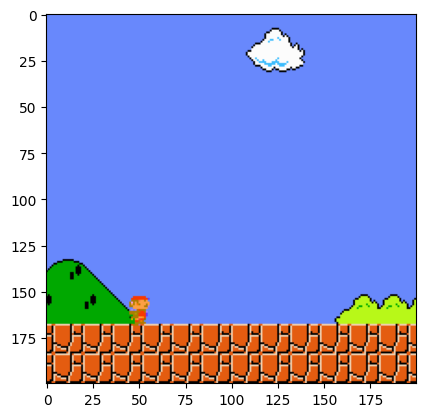

In [61]:
# Save an animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

def update_frames(frame):
    animation_image.set_array(animation_states[frame])
    return animation_image,

test_frames, test_acts, test_next_frames = dataset.sample(1, n_actions, seq_len=4)
animation_states = []
test_action = F.one_hot(torch.tensor(1),n_actions).float().cuda()

animation_states.append(test_frames[0,:3,:,:].permute(1,2,0).detach().cpu().numpy().astype(int))
animation_states.append(test_frames[0,3:6,:,:].permute(1,2,0).detach().cpu().numpy().astype(int))
animation_states.append(test_frames[0,6:9,:,:].permute(1,2,0).detach().cpu().numpy().astype(int))
animation_states.append(test_frames[0,9:12,:,:].permute(1,2,0).detach().cpu().numpy().astype(int))

for i in range(60):
  prior_latents = infnet.prior_sample(1).cuda()
  predicted_frame = model.predict(test_frames, test_action, prior_latents)
  animation_states.append(predicted_frame[0].permute(1,2,0).detach().cpu().numpy().astype(int))
  test_frames = torch.cat([test_frames[:,3:12,:,:], predicted_frame], dim=1)

fig, ax = plt.subplots()

animation_image = ax.imshow(animation_states[0])
ani = animation.FuncAnimation(fig, update_frames, frames=len(animation_states), blit=True)
ani.save('walk_right.mp4')
ani